# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

   **План проекта:**
   
   1.Загрузите и подготовьте данные. Поясните порядок действий.

   2.Обучите и проверьте модель для каждого региона:
   * Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
   * Обучите модель и сделайте предсказания на валидационной выборке.
   * Сохраните предсказания и правильные ответы на валидационной выборке.
   * Напечатайте на экране средний запас сырья и RMSE модели.
   * Проанализируйте результаты.
   3.Подготовьтесь к расчёту прибыли:
   * Сохраните в коде все ключевые значения для расчётов.
   * Посчитайте минимальный средний объём сырья в месторождениях региона, достаточный для его разработки.Напишите выводы.
   * Напишите функцию для расчёта прибыли по набору отобранных месторождений и предсказаний модели.
   4.Посчитайте риски и прибыль для каждого региона:
   * Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
   * Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков.
   * Напишите выводы: предложите регион для разработки месторождений и обоснуйте выбор.

## Загрузка и подготовка данных

    Данные геологоразведки трёх регионов находятся в файлах: geo_data_0.csv // geo_data_1.csv // geo_data_2.csv

    id — уникальный идентификатор месторождения;
    f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
    product — объём запасов в месторождении (тыс. баррелей).

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st

# Настройка, чтобы текст в ячейке отображался весь.
pd.set_option('display.max_colwidth', None)
# Настроим 2 знака после точки в float и разделение запятой тысячные до запятой.
pd.set_option('display.float_format', '{:,.2f}'.format)
# Уберем сообщения об ошибке -цепного присваивания.
pd.options.mode.chained_assignment = None

# Для масштабирования количественных данных.
from sklearn.preprocessing import StandardScaler
# Для подбора гиперпараметров и разделения на выборки.
from sklearn.model_selection import train_test_split
# Выгрузим модель линейной регрессии.
from sklearn.linear_model import LinearRegression
# Выгрузим показатели эффективности модели Линейной регрессии.
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Для построения графиков
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')


# Для вывода результатов.
from IPython.display import display

In [2]:
# Прочитаем файл данных и укажем колонки,
# которые подходят для построения модели (уберем RowNumber, CustomerId, Surname).
file_list=['datasets/geo_data_0.csv','datasets/geo_data_1.csv','datasets/geo_data_2.csv']
num=0
while num<=2:
  try:
    globals()['data' + str(num)]=pd.read_csv(file_list[num],usecols=['f0','f1','f2', 'product'])
  except:
    globals()['data' + str(num)]= pd.read_csv('https://code.s3.yandex.net/'+file_list[num],usecols=['f0','f1','f2', 'product'])
  num+=1

In [3]:
# Проверим, что мы не сохранили один и тот же датасет в разные переменные.
any((data0.equals(data1),data2.equals(data1),data0.equals(data2)))

False

In [4]:
# Создадим резервные копии датафреймов для возможности сравнения.

df0, df1, df2=(data0.copy(deep=True),
data1.copy(deep=True),
data2.copy(deep=True))

In [5]:
# Выведем общую информацию о датафреймах.

data_dict={'Датафрейм 0 региона':data0,'Датафрейм 1 региона': data1, 'Датафрейм 2 региона':data2}

for i in range(len(data_dict)):
  print ('\n'*2)
  print (list(data_dict.keys())[i],'-общая информация')
  print('\n'*2)
  list(data_dict.values())[i]. info()




Датафрейм 0 региона -общая информация



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB



Датафрейм 1 региона -общая информация



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB



Датафрейм 2 региона -общая информация



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 col

In [6]:
# Выведем описание датафреймов.

for i in range(len(data_dict)):
  print ('\n'*2)
  print (list(data_dict.keys())[i],'-описание данных методом "describe"')
  print('\n'*2)
  print (list(data_dict.values())[i].describe())




Датафрейм 0 региона -описание данных методом "describe"



              f0         f1         f2    product
count 100,000.00 100,000.00 100,000.00 100,000.00
mean        0.50       0.25       2.50      92.50
std         0.87       0.50       3.25      44.29
min        -1.41      -0.85     -12.09       0.00
25%        -0.07      -0.20       0.29      56.50
50%         0.50       0.25       2.52      91.85
75%         1.07       0.70       4.72     128.56
max         2.36       1.34      16.00     185.36



Датафрейм 1 региона -описание данных методом "describe"



              f0         f1         f2    product
count 100,000.00 100,000.00 100,000.00 100,000.00
mean        1.14      -4.80       2.49      68.83
std         8.97       5.12       1.70      45.94
min       -31.61     -26.36      -0.02       0.00
25%        -6.30      -8.27       1.00      26.95
50%         1.15      -4.81       2.01      57.09
75%         8.62      -1.33       4.00     107.81
max        29.42      18.7

In [7]:
# Посмотрим на первые 5 строк датафреймов.

for i in range(len(data_dict)):
  print ('\n'*2)
  print (list(data_dict.keys())[i],'-первые 5 строк таблицы')
  print('\n'*2)
  print (list(data_dict.values())[i].head())




Датафрейм 0 региона -первые 5 строк таблицы



     f0    f1   f2  product
0  0.71 -0.50 1.22   105.28
1  1.33 -0.34 4.37    73.04
2  1.02  0.15 1.42    85.27
3 -0.03  0.14 2.98   168.62
4  1.99  0.16 4.75   154.04



Датафрейм 1 региона -первые 5 строк таблицы



      f0     f1    f2  product
0 -15.00  -8.28 -0.01     3.18
1  14.27  -3.48  1.00    26.95
2   6.26  -5.95  5.00   134.77
3 -13.08 -11.51  5.00   137.95
4  12.70  -8.15  5.00   134.77



Датафрейм 2 региона -первые 5 строк таблицы



     f0    f1    f2  product
0 -1.15  0.96 -0.83    27.76
1  0.26  0.27 -2.53    56.07
2  0.19  0.29 -5.59    62.87
3  2.24 -0.55  0.93   114.57
4 -0.52  1.72  5.90   149.60





Датафрейм 0 региона -гистограммы данных по колонкам.





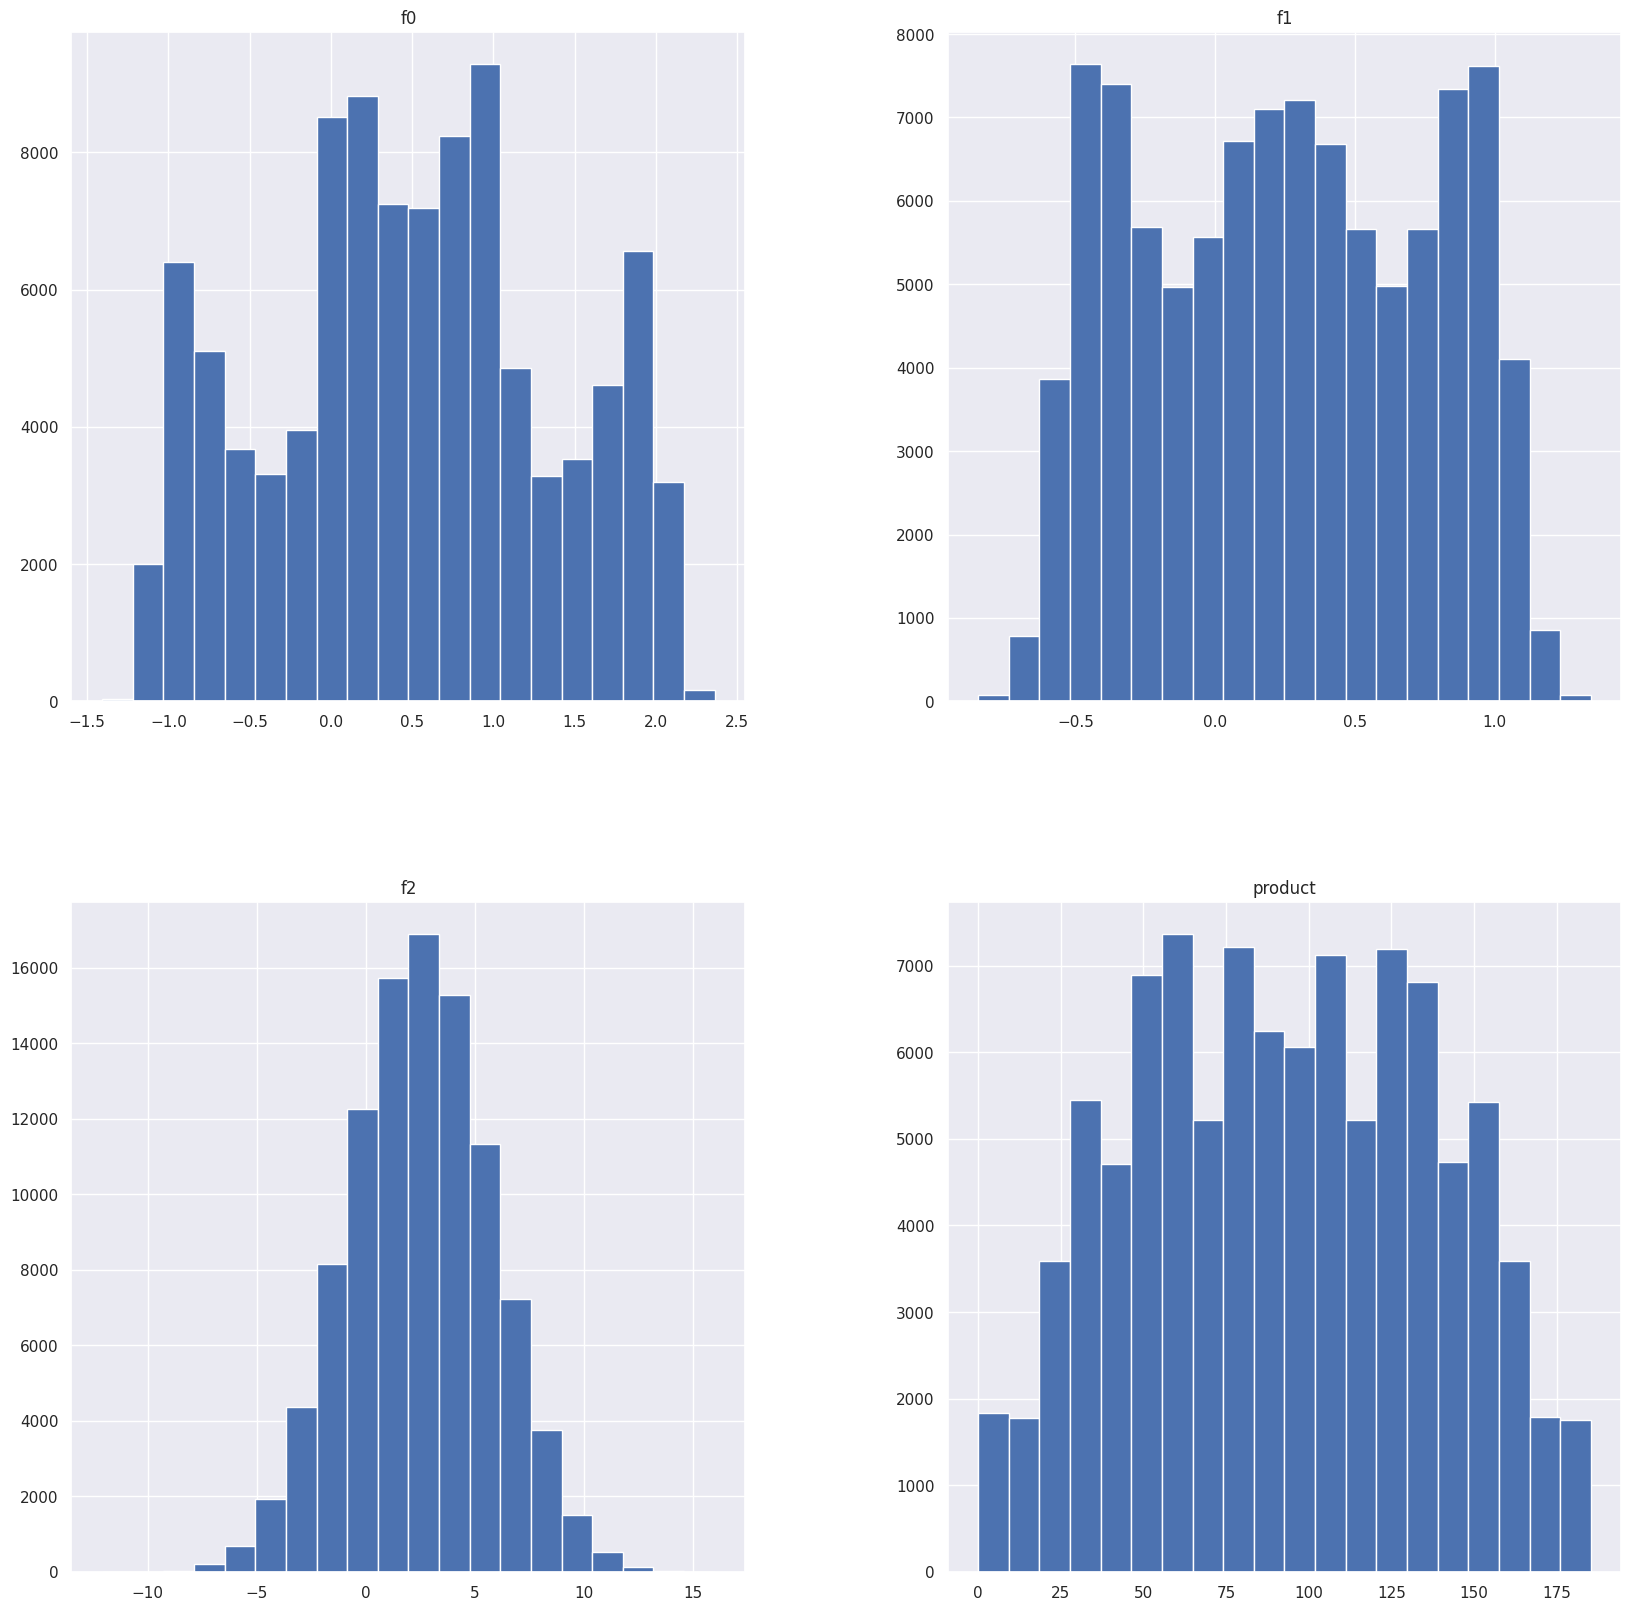




Датафрейм 1 региона -гистограммы данных по колонкам.





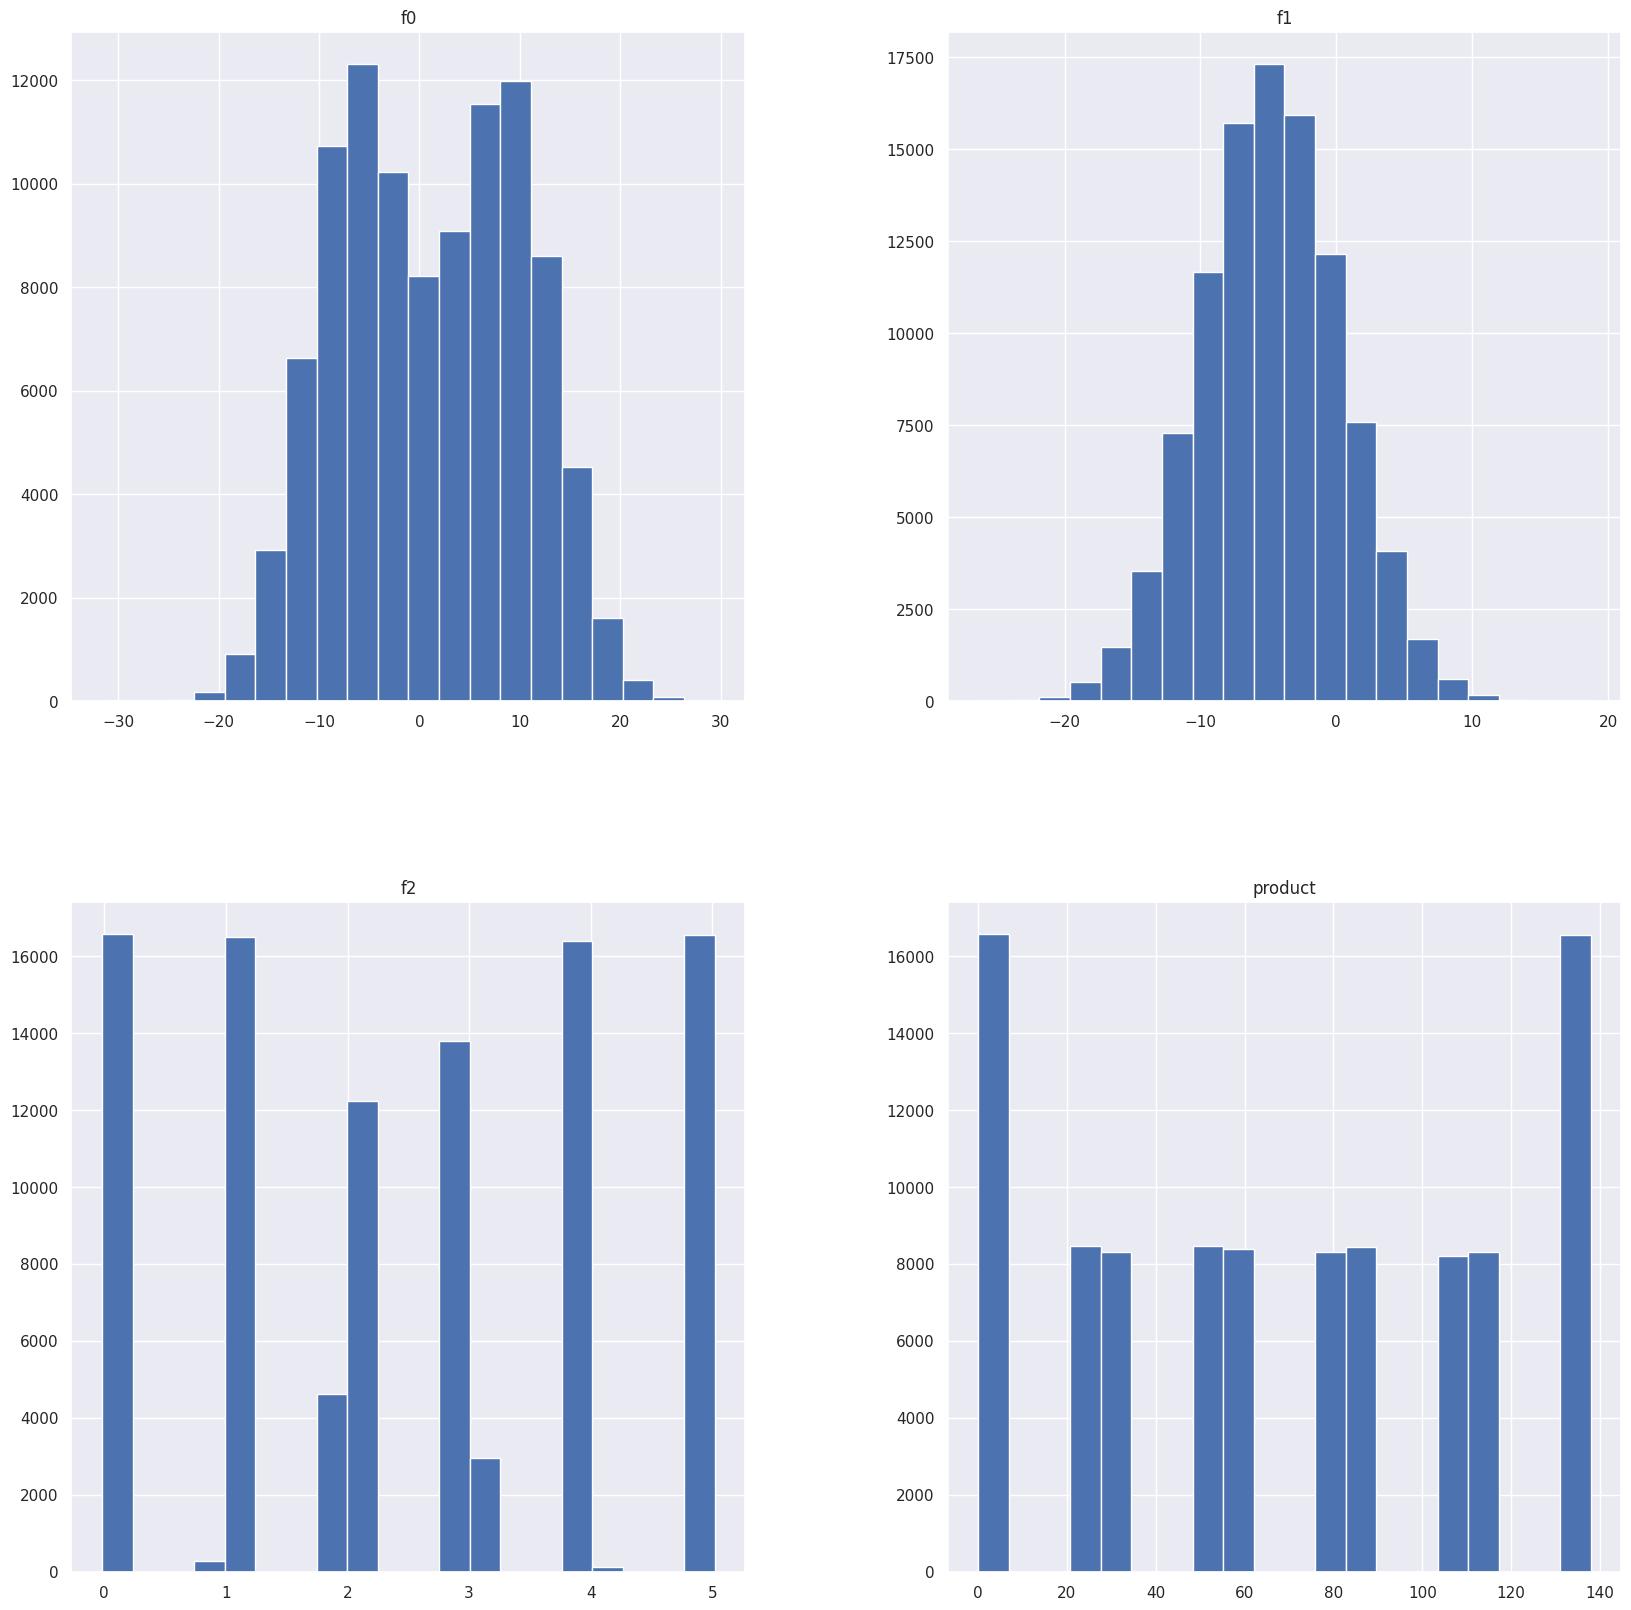




Датафрейм 2 региона -гистограммы данных по колонкам.





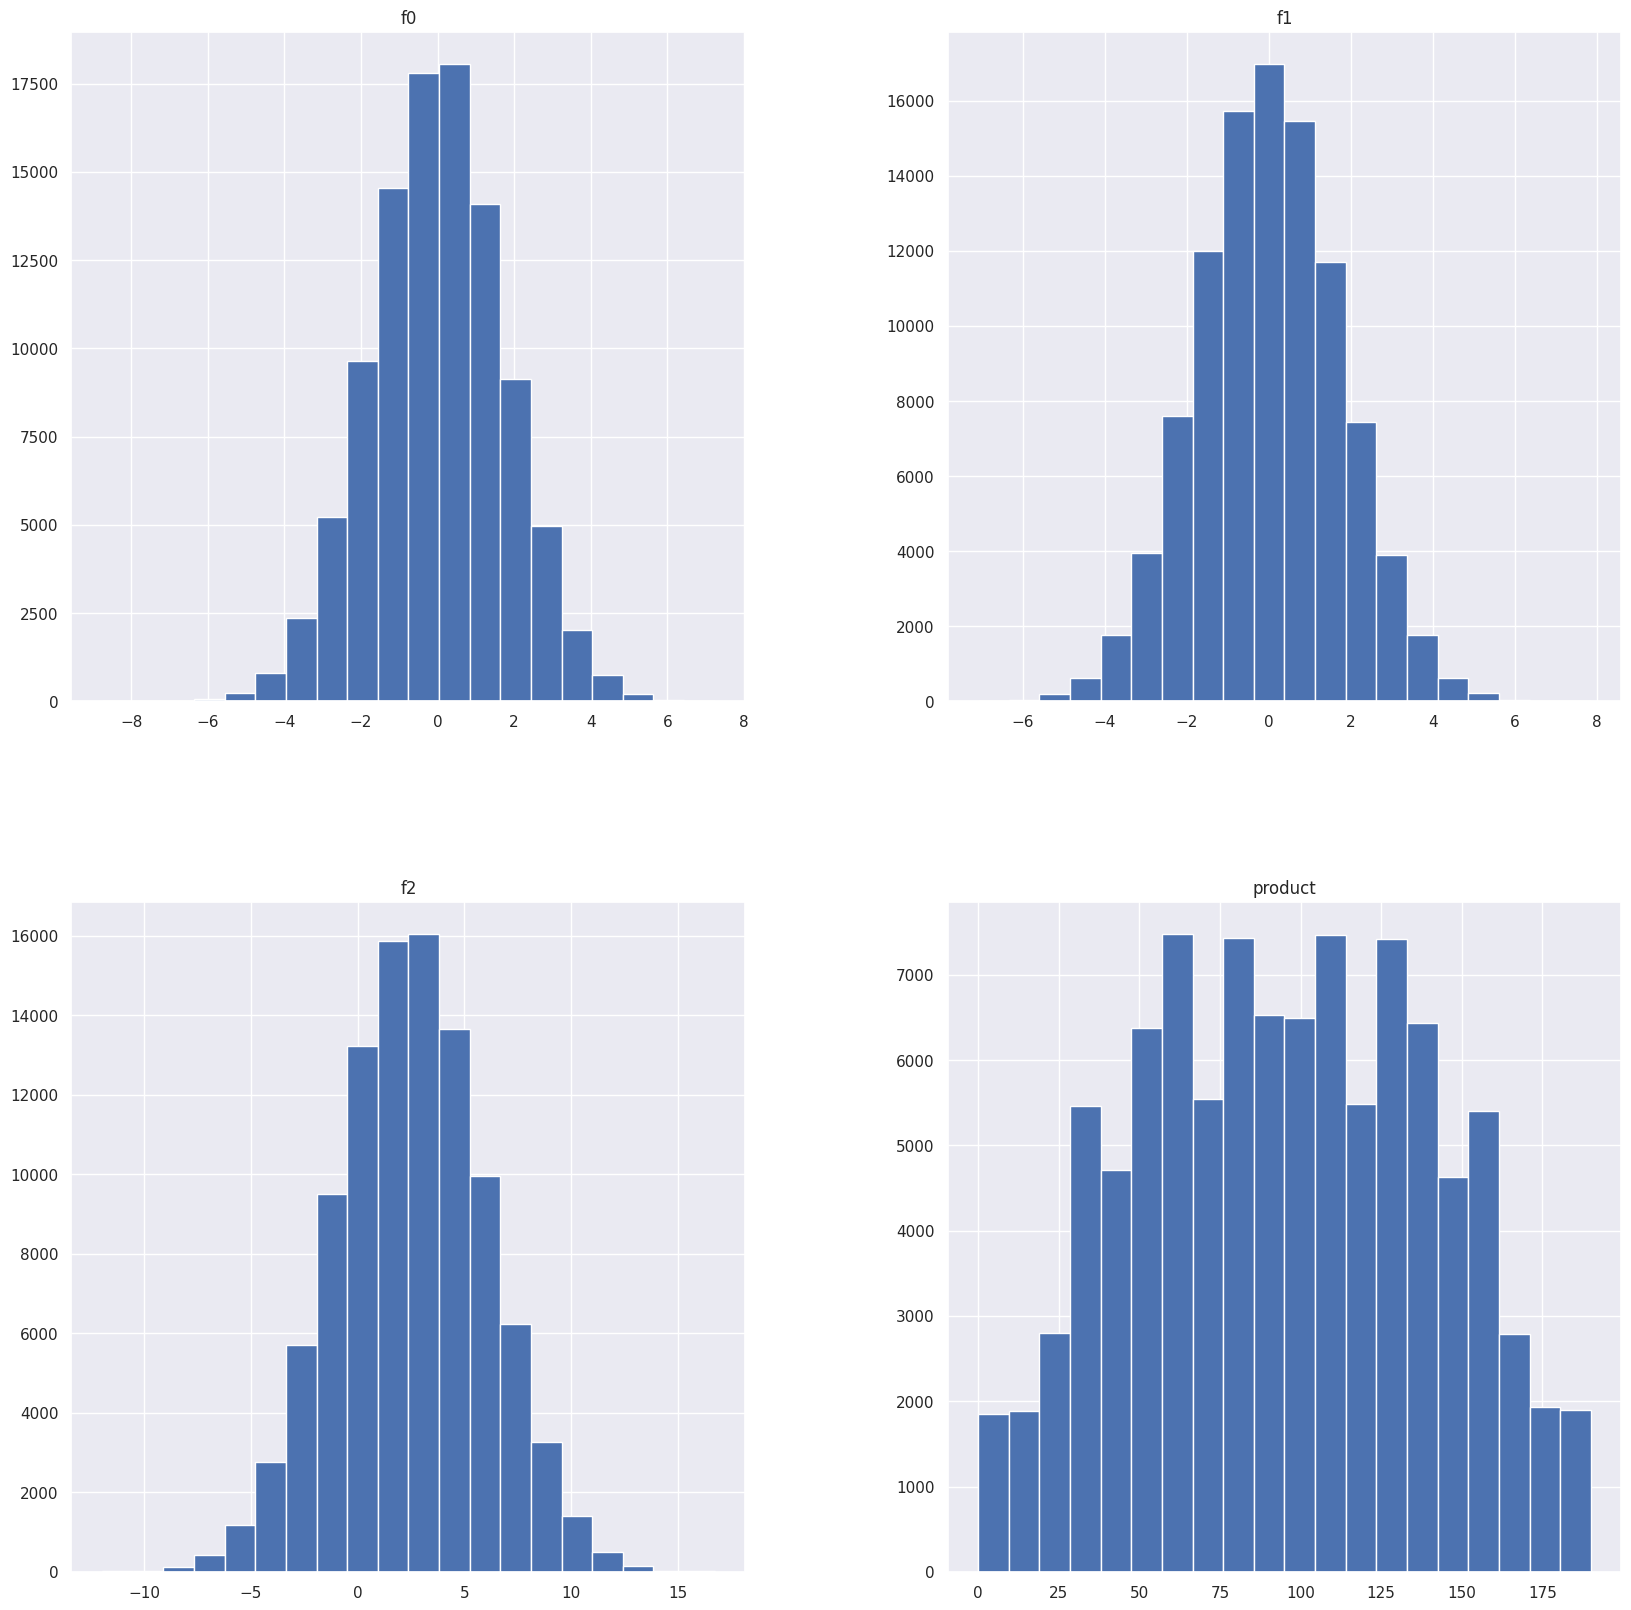

In [8]:
# Создадим гистограммы колонок датафреймов.

for i in range(len(data_dict)):
  print ('\n'*2)
  print (list(data_dict.keys())[i],'-гистограммы данных по колонкам.')
  print('\n'*2)
  list(data_dict.values())[i].hist(figsize=(20,20),bins=20)
  plt. show()

Датафрейм 0 региона


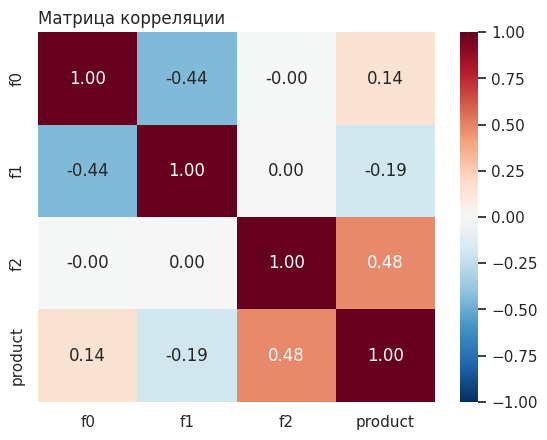


Датафрейм 1 региона


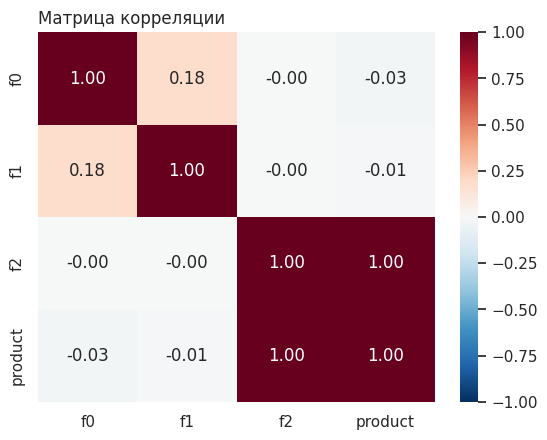


Датафрейм 2 региона


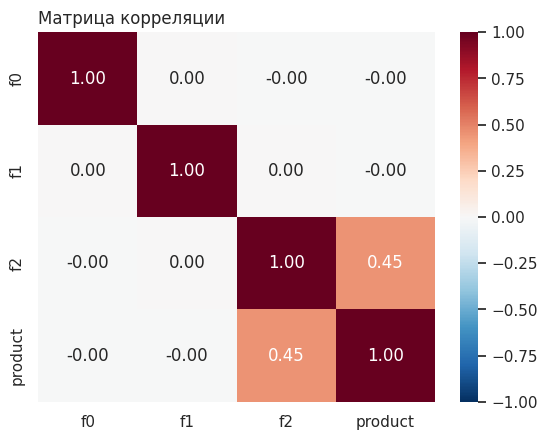

In [9]:
# построим матрицу корреляции.

for i in range(len(data_dict)):
  print (list(data_dict.keys())[i])
  sns.heatmap((list(data_dict.values())[i]).corr(),cmap='RdBu_r',annot=True,vmin=-1, vmax=1, fmt=".2f",center= 0,cbar=True)
  plt.title("Матрица корреляции", loc="left")
  plt. show()
  print()

Датафрейм 0 региона


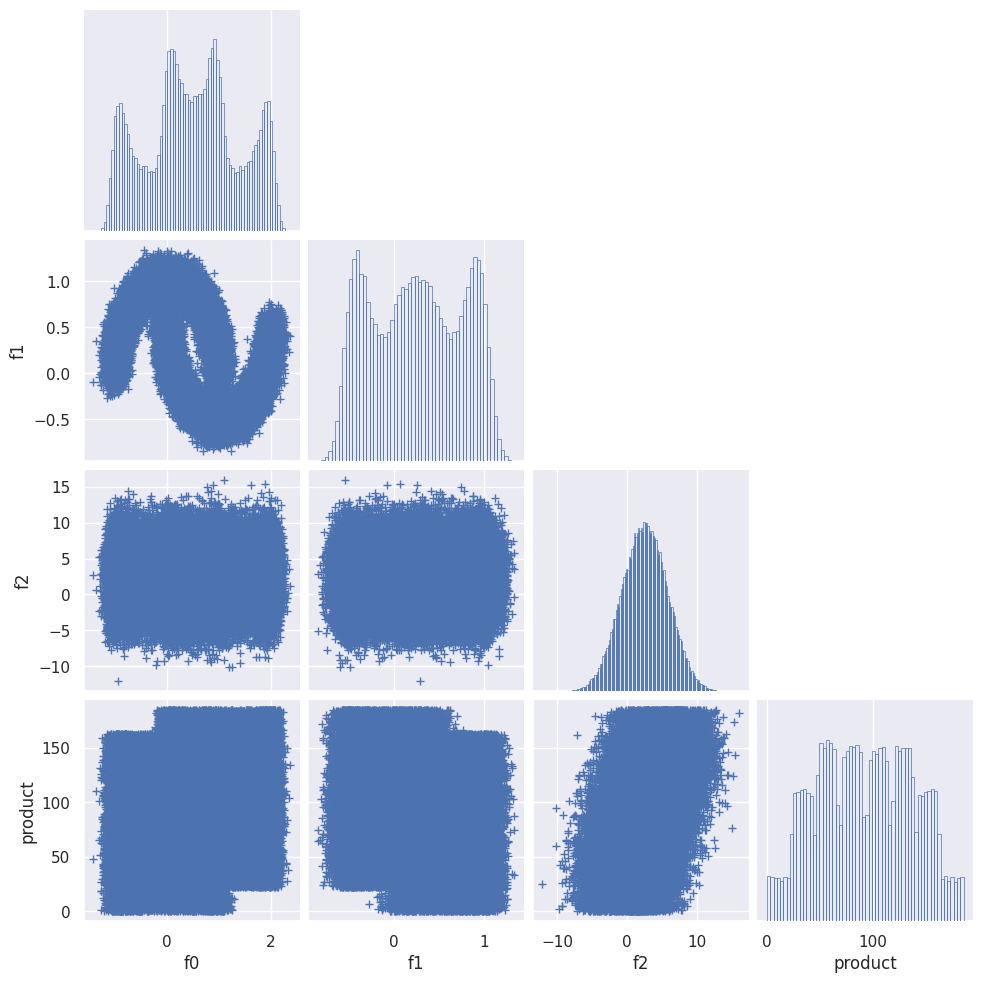


Датафрейм 1 региона


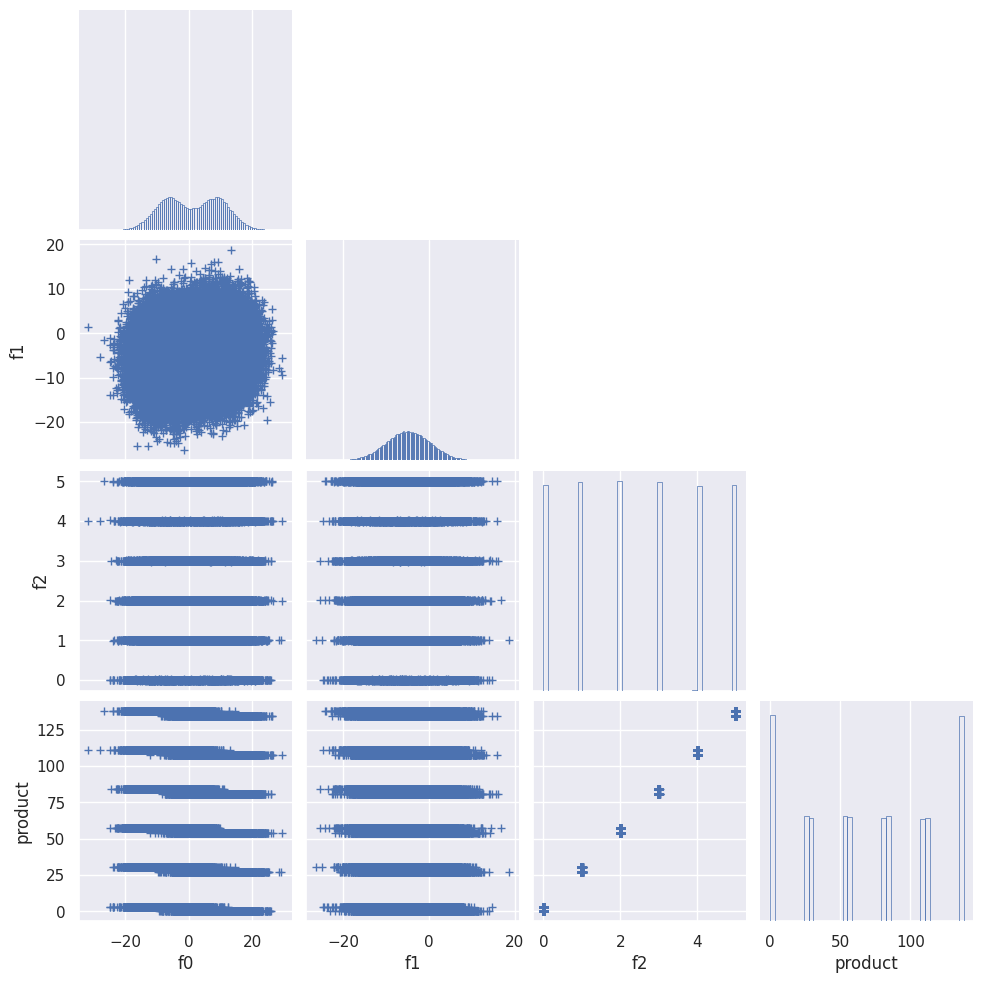


Датафрейм 2 региона


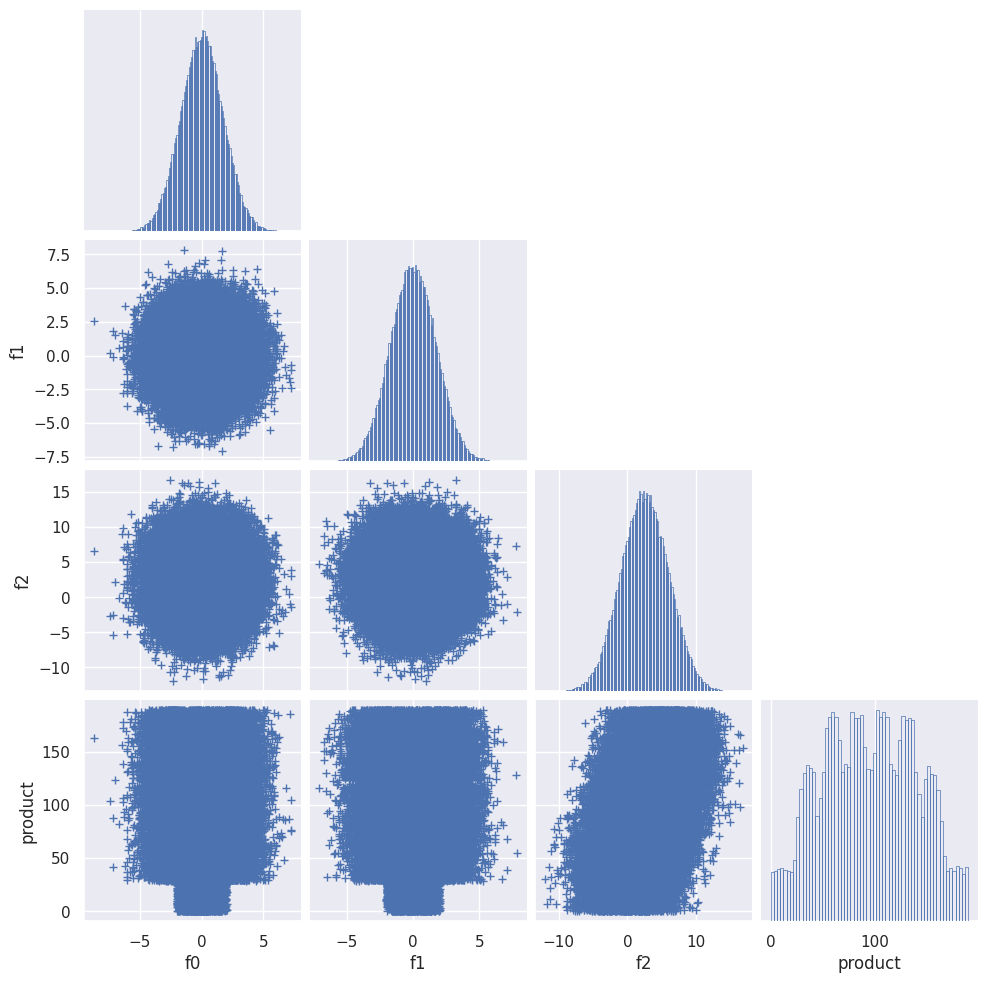

In [10]:
# построим парные графики.


for i in range(len(data_dict)):
  print (list(data_dict.keys())[i])
  sns.pairplot(data=(list(data_dict.values())[i]),plot_kws=dict(marker="+", linewidth=1),
diag_kws=dict(fill=False),corner=True)
  plt. show()
  print()

In [11]:
# Проверим данные на дубликаты.
data0.duplicated().sum(), data1.duplicated().sum(), data2.duplicated().sum()

(0, 0, 0)

In [12]:
# Посмотрим количество 0 в датафреймах по колонкам.

cols=data0.columns.tolist()


for i in range(len(data_dict)):
  print ('\n'*2)
  print (list(data_dict.keys())[i],'-количество нулей')
  for j in range(len(cols)):
    print (cols[j])
    print ((list(data_dict.values())[i][cols[j]]==0). sum(). sum())
    print ('\n'*1)




Датафрейм 0 региона -количество нулей
f0
0


f1
0


f2
0


product
1





Датафрейм 1 региона -количество нулей
f0
0


f1
0


f2
0


product
8235





Датафрейм 2 региона -количество нулей
f0
0


f1
0


f2
0


product
1




In [13]:
# Посмотрим количество уникальных значений в датафреймах по колонкам.

cols=data0.columns.tolist()


for i in range(len(data_dict)):
  print ('\n'*2)
  print (list(data_dict.keys())[i],'-количество уникальных значений')
  for j in range(len(cols)):
    print (cols[j])
    print (list(data_dict.values())[i][cols[j]].nunique())
    print ('\n'*1)




Датафрейм 0 региона -количество уникальных значений
f0
100000


f1
100000


f2
100000


product
100000





Датафрейм 1 региона -количество уникальных значений
f0
100000


f1
100000


f2
100000


product
12





Датафрейм 2 региона -количество уникальных значений
f0
100000


f1
100000


f2
100000


product
100000




In [14]:
# Посмотрим на значения в целевом признаке датафрейма 1 региона.

data1['product'].value_counts(sort=True,dropna=False,ascending=True)

107.81    8201
137.95    8233
0.00      8235
110.99    8303
134.77    8304
30.13     8306
80.86     8320
3.18      8337
57.09     8390
84.04     8431
26.95     8468
53.91     8472
Name: product, dtype: int64

### Вывод

На данном шаге был проведен импорт необходимых библиотек для дальнейшей работы с данными и построения модели Линейной регрессии. Данные были загружены и сохранены. Колонка с id была удалена в каждом датафрейме, т. к. не несёт информации для дальнейшего обучения модели.

Данные были проанализированы и выявлены следующие моменты:

* В каждом датафрейме не обнаружены пропуски. Дубликаты же имелись в колонках с id, но при этом проблема никак не распространялась на значения остальных колонок - они не дублировались между собой, поэтому было принято решение убрать колонки с id на этапе загрузки. Так же дублирующиеся значения были найдены в колонке 'product' Регион 1, в количестве 12 значений, которые почти равномерно разделяют весь датасет. Это говорит о дискретности данных в ней.

* Все датафреймы имеют одинаковую структуру колонок, которые в дальнейшем для обучения модели мы разделим на признаки (f0, f1, f2) и целевой признак, содержащий информацию о количестве продукта в тыс. ед. - product.

* Размер датафреймов идентичен.Есть различия по распределению продукции по датафремам/регионам.

* Датафрейм 1 региона содержит 8235 нулевых значений продукта. С учетом 12 групп по количеству продукта, включая группу с 0-ым значением можно предположить, что при замерах использовалась либо другая техника, либо она была как-то иначе откалибрована. В любом случае на это стоит обратить внимание клиента.

* Были построены матрицы корреляции, в результате которых мультиколлинеарность факторов не найдена, что так же не найдено на парном графике рассеивания. Замечена высокая корреляция между признаком 'f2' и 'product' в датасете 1 Региона, но это может влиять позитивно на обучение модели. Так же есть невысокая корреляция между факторами и целевым признаком в остальных датасетах, но зависимость между самими признаками отсутствует.

## Обучение и проверка модели

In [15]:
# Создадим функцию для обучения модели.

def make_model(data):
  ''' Функция производит обучение модели Линейной регрессии с возвратом
  целевого признака на валидационной выборке, предсказанных значений на валидационной выборке,
  средних предсказанных значений по добыче нефти и коэффициенты RMSE,  R2 и MAE.
  '''
  features = data.drop('product', axis=1)
  target = data['product']

# Разделим данные на выборки.

  f_train, f_valid, t_train,t_valid = train_test_split(features, target,
test_size=.25,
random_state=12345)

# Масштабируем количественные признаки.

  scaler = StandardScaler()
  f_train = scaler.fit_transform(f_train)
  f_valid = scaler. transform (f_valid)

# Обучим модель.

  model = LinearRegression()
  model. fit(f_train, t_train)


  predicted_valid = model.predict(f_valid)
  mean_predicted = predicted_valid. mean ()
  r_mse = mean_squared_error(t_valid,predicted_valid)**.5
  mae=mean_absolute_error(predicted_valid,t_valid)
  r2=model.score(f_valid,t_valid)


  return (t_valid.reset_index(drop=True),pd.Series(predicted_valid,index=range(25_000)),mean_predicted,r_mse,mae,r2 )

In [16]:
# Создадим функцию для обучения модели.

def make_model(data):
    ''' Функция производит обучение модели Линейной регрессии с возвратом
    целевого признака на валидационной выборке, предсказанных значений на валидационной выборке,
    средних предсказанных значений по добыче нефти и коэффициенты RMSE,  R2 и MAE.
    '''
    features = data.drop('product', axis=1)
    target = data['product']

    # Разделим данные на выборки.

    f_train, f_valid, t_train,t_valid = train_test_split(features, target,
    test_size=.25,
    random_state=12345)

    # Масштабируем количественные признаки.

    scaler = StandardScaler()
    f_train = scaler.fit_transform(f_train)
    f_valid = scaler. transform (f_valid)

    # Обучим модель.

    model = LinearRegression()
    model. fit(f_train, t_train)


    predicted_valid = model.predict(f_valid)
    mean_predicted = predicted_valid. mean ()
    r_mse = mean_squared_error(t_valid,predicted_valid)**.5
    mae=mean_absolute_error(predicted_valid,t_valid)
    r2=model.score(f_valid,t_valid)


    return (t_valid.reset_index(drop=True),pd.Series(predicted_valid,index=range(25_000)),mean_predicted,r_mse,mae,r2 )

In [17]:
# Создадим переменные с результатами работы функции по всем 3м регионам.


for i in range(len(data_dict)):
  (globals()['t_valid_' + str(i)],
globals()['predicted_valid_' + str(i)],
globals()['mean_predicted_'+str(i)],
globals()['rmse_'+str(i)],
globals()['mae_'+str(i)],
globals()['r2_'+str(i)])=make_model(
list(data_dict.values())[i])

In [18]:
# Создадим датафрейм с результатами обученных моделей.

details=({'Средний запас предсказанного сырья':[ mean_predicted_0,mean_predicted_1, mean_predicted_2],
'RMSE':[rmse_0, rmse_1, rmse_2],
'MAE':[mae_0, mae_1, mae_2],
'R2':[r2_0,r2_1,r2_2]})
model_frame=pd.DataFrame(details,index=list(data_dict.keys()))

In [19]:
# Перевернем датафрейм.

model_frame.transpose()

,Датафрейм 0 региона,Датафрейм 1 региона,Датафрейм 2 региона
Средний запас предсказанного сырья,92.59,68.73,94.97
RMSE,37.58,0.89,40.03
MAE,30.92,0.72,32.79
R2,0.28,1.00,0.21


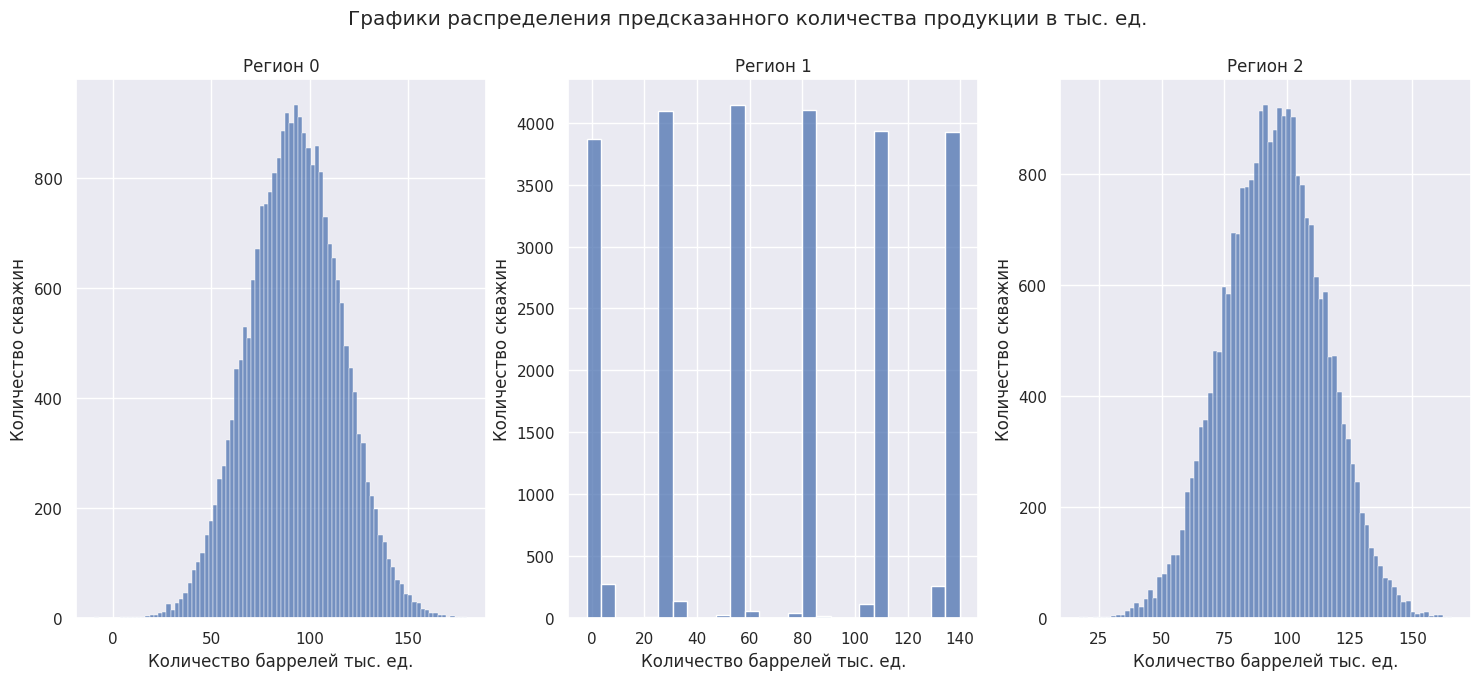

In [20]:
# Построим графики распределения предсказанной продукции

fig, axis = plt.subplots(nrows=1,ncols=3,figsize=[18,7])
fig. suptitle('Графики распределения предсказанного количества продукции в тыс. ед. ')
sns.histplot(data = predicted_valid_0,ax=axis[0]).set(title='Регион 0',xlabel='Количество баррелей тыс. ед.', ylabel='Количество скважин')
sns.histplot(data = predicted_valid_1,ax=axis[1]).set(title='Регион 1',xlabel='Количество баррелей тыс. ед.', ylabel='Количество скважин')
sns.histplot(data = predicted_valid_2,ax=axis[2]).set(title='Регион 2',xlabel='Количество баррелей тыс. ед.', ylabel='Количество скважин')
plt. show ()

### Вывод

   Модели обучены, метрики получены. По качеству модель второго и нулевого региона работают наравне на основе метрики r2. Самый большой средний запас продукции у нулевого региона, затем у второго региона.

 Как было заявлено ранее, что, чем сильнее коррелирует признак с целевым, тем сильнее линейная зависимость и тем лучше для обучения линейной регрессии, так и произошло в моделью по Региону 1.Она гораздо лучше справляется со своими задачами в сравнении с остальными моделями. Так же в это сыграл свою роль факт о том, что в дата сете 1 региона данные по продукту дискретны. И составляют из себя всего 12 значений.

## Подготовка к расчёту прибыли

* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

* Бюджет на разработку скважин в регионе — 10 млрд рублей.

* При нынешних ценах один баррель сырья приносит 450 рублей дохода.

* Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [21]:
# Создадим константные переменные для дальнейших расчётов.

# Количество скважин для исследования
MAX_POINT=500

# Количество лучших скважин для разработки
BEST_POINT=200

# Бюджет региона.
BUDGET=10_000_000_000/1_000

# Бюджет на 200 лучших скважин.
DRILL_WELL=BUDGET/BEST_POINT # 50_000

# Цена за 1 единицу продукта.
BURREL=450

In [22]:
print( f'Минимальный объем добычи нефти в 1 скважине: \n\n {(min_output := (DRILL_WELL/BURREL)):_.2f} тыс. баррелей')
print()
print( f'Минимальный объем добычи нефти \nв регионе на 200 скважин: \n\n {(min_sum_output := (200*min_output)):_.2f} тыс. баррелей')

Минимальный объем добычи нефти в 1 скважине: 

 111.11 тыс. баррелей

Минимальный объем добычи нефти 
в регионе на 200 скважин: 

 22_222.22 тыс. баррелей


In [23]:
# Посмотрим на средний объём скважин прогнозируемый моделями и количество скважин с объемом выше минимального.

min_predict_0=predicted_valid_0.sort_values()[predicted_valid_0>min_output].count()
min_predict_1=predicted_valid_1.sort_values()[predicted_valid_0>min_output].count()
min_predict_2=predicted_valid_2.sort_values()[predicted_valid_0>min_output].count()
model_frame['Количество скважин с объемом >111.11 тыс. баррелей']=[min_predict_0,min_predict_1,min_predict_2]
model_frame.iloc[:, [0,-1]].transpose()

,Датафрейм 0 региона,Датафрейм 1 региона,Датафрейм 2 региона
Средний запас предсказанного сырья,92.59,68.73,94.97
Количество скважин с объемом >111.11 тыс. баррелей,"5,388.00","5,388.00","5,388.00"


В датафрейме выше видно, что средние прогнозируемые значения ниже необходимого минимального объема добычи, но при этом в количество скважин со значением >111.11 тыс. баррелей составляет 5 388 скважин, что вполне достаточно для выбора 200 лучших для разработки точек.

In [24]:
# Функция для расчёта  коэффициента ROI.
roi=lambda rev, invest: (rev-invest) /invest

In [25]:
# Создадим функцию для расчета прибыли и рисков.

finality=pd.DataFrame()
state = np.random.RandomState(12345)
def profit_calc(target, predicted, count=BEST_POINT, numb=MAX_POINT,state = state) :
  values, risk= [], 0
  for i in range(1000):
    target_subsample = target.sample(n=numb, replace=True, random_state=state)
    probs_subsample_sorted = predicted[target_subsample.index].sort_values(ascending=False)
    selection = target_subsample[probs_subsample_sorted.index][:count]
    if ((selection.sum()*BURREL)-BUDGET)<0:
      risk+=1
    values.append((selection.sum()*BURREL))
  values = pd.Series(values)
  mean = values.mean()
  roi_= abs(roi(mean, BUDGET))
  low_boundary = values.quantile(.025)
  high_boundary = values.quantile(.975)
  confidence_interval = st.t.interval(0.95,df=len(values)-1,loc=values.mean(),scale =values.sem())
  total_profit = mean - BUDGET
  lost_fear=(risk/1000) *100

  details={'Средняя выручка тыс. руб. ':[mean],
'ROI':[roi_],
'Нижняя граница прибыли тыс. руб.':[low_boundary],
'Верхняя граница прибыли тыс. руб. ':[high_boundary],
'Средняя прибыль тыс. руб. ':[total_profit],
'95% доверительный интервал по средней выручке':[confidence_interval],
'Риск в %':[lost_fear]}

  new_info=pd.DataFrame(details,columns=details.keys(),index=[len(finality)])
  return new_info

### Вывод

    На данном этапе работы созданы константные переменные и написана функция для расчета прибыли и рисков с применением техники Bootstrap.

## Расчёт прибыли и рисков

In [26]:
finality=pd.concat([finality,profit_calc(t_valid_0,predicted_valid_0)], ignore_index=True)
finality=pd.concat([finality,profit_calc(t_valid_1,predicted_valid_1)], ignore_index=True)
finality=pd.concat([finality,profit_calc(t_valid_2,predicted_valid_2)], ignore_index=True)
finality.index.rename('Регион',inplace=True)
finality

,Средняя выручка тыс. руб.,ROI,Нижняя граница прибыли тыс. руб.,Верхняя граница прибыли тыс. руб.,Средняя прибыль тыс. руб.,95% доверительный интервал по средней выручке,Риск в %
Регион,,,,,,,
0,"10,425,938.53",0.04,"9,897,909.91","10,947,976.35","425,938.53","(10408732.207068698, 10443144.846752485)",6.00
1,"10,518,259.49",0.05,"10,128,123.23","10,953,612.98","518,259.49","(10505249.881576622, 10531269.105818028)",0.30
2,"10,420,194.01",0.04,"9,884,147.39","10,989,629.94","420,194.01","(10402528.70365036, 10437859.30703774)",6.20


### Вывод


   Рекомендуем к разработке 1 Регион, где риск ниже требуемого (0.3%). Кроме того доверительный интервал показывает, что даже при не очень удачном выборе разработка скважин окупится.
   Так же следует обратить внимание на присутствие дублированных данных в номерах id,а так же на дискретность значений в данных колонки "product" и присутствуе нулевых значений. Возможно это связано со сбоем колибровки оборудования и проведением повторных замеров под тем же id. В результате в данные могли попасть ошибочные данные,которые могли исказить обученную модель.